In [42]:
#Tasking Simuation
#TODO:
#encapsulate data

import matplotlib.pyplot as plt
import math
import numpy as np
import pandas as pd
from datetime import datetime
import matplotlib.animation as animation

#From business logic boundaries
priority_scheme = {
    "assured" : 3000,
    "emergency_response": range(2500,3000),
    "platinum" : range(2400,2500), #next day - few days 
    "gold" : range(2300,2450),
    "cc_silver": range(2200,2300),
    "cc_bronze": range(2100,2200),
    "cc_presales" : range(2001,2100),
    "ts_marketing" : range(1000,1200), #unless bumped 
    "flex_silver" : range(1750,2000),
    "flex_bronze" : range(1500,1750),
    "hp_nonrev" : range(1000,1500),
    "presales/engagement" : range(500,1000),
    "calib" : range(50,500),
    "nts_marketing" : range(50,500),
    "background" : range(1,50),
    "google" : 1200
}

def strToDate(date_str):
    return pd.Timestamp(datetime.strptime(date_str, "%b %d, %Y, %X %p")).dayofyear
    
    
#Creates Order object
class Order():
    
    def __init__(self, order_id, start, end, attempts, pl_type):
        self.start = start
        self.order_id = order_id
        self.end = end
        self.pl_type = pl_type
        self.attempts = 0
        self.attempt_dates = []
        self.pl_limits = priority_scheme.get(self.pl_type)
        self.init_priority = min(self.pl_limits)
        self.priority_x = np.linspace(start, end, end-start)
        #creates array of priority values over TOI
        self.priority_y = [self.getPriorityLog(i) for i in self.priority_x] 
        
    @staticmethod
    def fromRow(row, pl_type):
        return Order(row['order_id'], strToDate(row['start_time']), strToDate(row['end_time']), row['capture_count'],
                     pl_type)
    
    #Logistic growth based priority 
    def getPriorityLog(self, current_time):
        time_wrt_start = current_time - self.start
        midpoint = (self.end - self.start) / 2
        max_pl = max(self.pl_limits)
        min_pl = min(self.pl_limits)
        dif = max_pl - min_pl
        growth_rate = 0.5
        priority = min_pl + (dif / (1 + growth_rate* math.exp( - growth_rate * (time_wrt_start - 15))))
        return(priority)
        
    def drawPriorityGraph(self):
        plt.plot(self.priority_x, self.priority_y, label = self.order_id)
        plt.xlabel('time (days)')
        plt.ylabel('priority')
        plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)
        for i in self.attempt_dates:
            plt.annotate(str(i), (self.priority_x[i], self.priority_y[i]))
        
    def animate_graph(self):
        fig = plt.figure()
        axes = plt.gca()
        axes.set_xlim(self.start, self.end)
        axes.set_ylim(min(self.pl_limits), max(self.pl_limits))

        def animate(i):
            xs = []
            ys = []
    
            for j in self.priority_x:
                xs.append(self.priority_x)
                ys.append(self.priority_y)
            
        
        plt.xlabel('Date')
        plt.ylabel('Price')
        plt.title('Live graph with matplotlib')
        
        plt.show()
        ani = animation.FuncAnimation(fig, animate, interval = 1000)
        plt.close()
        ani

    #collect is DAYS AFTER START, not day-of-year
    def collect(self, time):
        self.attempt_dates.append(time)
        self.attempts += 1
        for i in range(time, self.end - self.start):
            self.priority_y[i] = self.getPriorityLog(self.start + i - time)

In [17]:
class OrderList():

    #Takes CSV file and outputs a group list of orders
    def __init__(self, csv_file, pl_type):
        self.order_list = []
        self.csv_file = csv_file
        self.df = pd.read_csv(csv_file)
        self.startdates = []
        self.enddates = []
        self.pl_type = pl_type

        for i in range(len(self.df)):
            order = Order.fromRow(self.df.loc[i], pl_type)
            self.order_list.append(order)
            self.startdates.append(order.start)
            self.enddates.append(order.end)
            
        self.num_orders = len(self.order_list) 
        self.min = min(self.startdates)
        self.max = max(self.enddates)

        self.df_update()
        
    def df_update(self): 
        for i in range(self.min, self.max):
            vals = []
            for j in range(0, self.num_orders):
                this = self.order_list[j]
                if(this.start <= i & i < this.end):  
                    vals.append(this.priority_y[i - this.start])
                else: 
                    vals.append(0)
            self.df['priority at day ' + str(i)] = vals

    def drawGroupGraph(self):
        for i in self.order_list:
            Order.drawPriorityGraph(i)
        
    #appends updated priority columns to 
    #def to_csv(self):
    
    #Simulates semi-random broker captures with a cluster of tasks
    def simulate(self):
        sat_capacity = 0.25 
        this = self.order_list
        for i in range(0, self.max - self.min - 1): #date 
            self.df_update()
            sorted_df = self.df.sort_values(by=['priority at day ' + str(self.min + i + 1)], ascending = False)
            max_bound = np.random.randint(0, 0.5 * self.num_orders) #max number of tasks
            collect = np.random.binomial(1,sat_capacity) 
            collect_orders = sorted_df['Unnamed: 0'][range(0, max_bound)] #top n indices
            if(collect == 1):
                for j in collect_orders:
                    self.order_list[j].collect(i)
                    #print(collect_orders)

/Users/keren/.local/lib/python3.7/site-packages/ipykernel_launcher.py:33: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider using pd.concat instead.  To get a de-fragmented frame, use `newframe = frame.copy()`


IndexError: index 91 is out of bounds for axis 0 with size 90

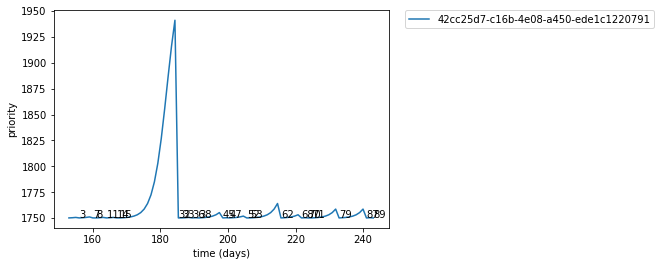

In [46]:
list1 = OrderList('test_area_updated.csv', "flex_silver")
list1.simulate()
list1.drawGroupGraph()

#sorted_df = list1.df.sort_values(by=['priority at day ' + str(296)], ascending = False)
#sorted_df
#print(list1.order_list[3].priority_y)
#list1.df.sort_values(by=['priority at day 296'], ascending = False)['Unnamed: 0'][0:3]

#### Two-order comparison 

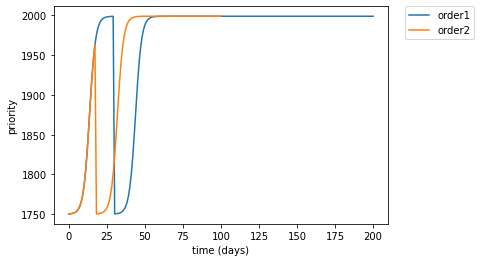

In [4]:
order1 = Order('order1', 0, 200, 0, "flex_silver")
order2 = Order('order2',0,100, 0, "flex_silver")
order1.collect(30)
order2.collect(18)
order1.drawPriorityGraph()
order2.drawPriorityGraph()

#### Single-order multiple collect simulation 

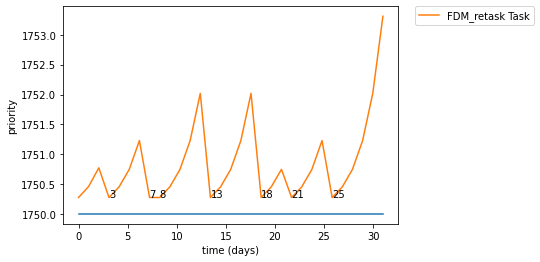

In [35]:
sim_order = Order('FDM_retask Task', 0, 31, 0, "flex_silver")
sim_order.collect(3)
sim_order.collect(7)
sim_order.collect(8)
sim_order.collect(13)
sim_order.collect(18)
sim_order.collect(21)
sim_order.collect(25)
plt.plot(np.linspace(0, 31, 30), np.full(30, 1750, int))
sim_order.drawPriorityGraph()

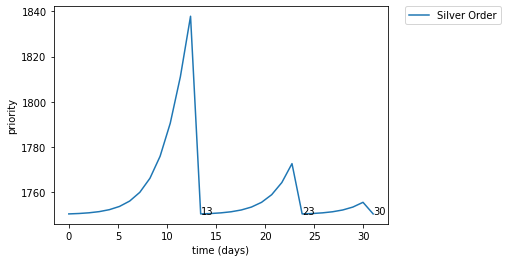

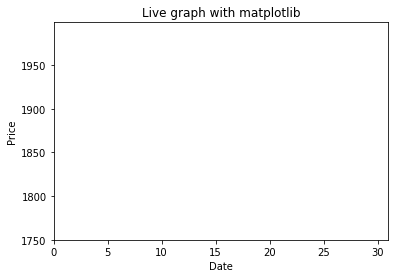

AttributeError: 'FuncAnimation' object has no attribute 'FuncAnimation'

In [45]:
sample_order = Order('Silver Order', 0, 31, 0, "flex_silver")
sample_2 = Order('Bronze Order', 0, 31, 0, "flex_bronze")

sample_order.collect(13)
sample_order.collect(23)
sample_order.collect(30)

sample_order.drawPriorityGraph()
ani = sample_order.animate_graph()


#sample_2.drawPriorityGraph()

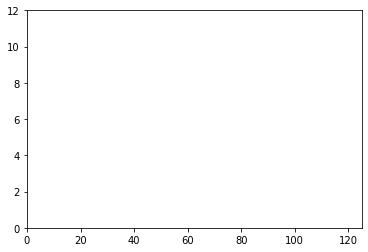

In [44]:
from matplotlib.animation import FuncAnimation

x_data = []
y_data = []

fig, ax = plt.subplots()
ax.set_xlim(0, 125)
ax.set_ylim(0, 12)
line, = ax.plot(0, 0)

def animation_frame(i):
    x_data.append(i *10)
    y_data.append(i)
    
    line.set_xdata(x_data)
    line.set_ydata(y_data)
    return line, 

plt.show()